In [1]:
import pandas as pd
import numpy as np
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
'''
NumPy: 1.24.3
scikit-learn: 1.5.2
TensorFlow: 2.17.0
'''

2024-10-20 23:23:01.778512: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-20 23:23:02.051378: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-20 23:23:02.458425: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-20 23:23:02.943473: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-20 23:23:03.076793: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-20 23:23:03.596945: I tensorflow/core/platform/cpu_feature_gu

'\nNumPy: 1.24.3\nscikit-learn: 1.5.2\nTensorFlow: 2.17.0\n'

In [2]:
data_pat = "/home/hadoop/Documents/historical_stock_data.csv"
print(data_pat)

/home/hadoop/Documents/historical_stock_data.csv


In [5]:
import pandas as pd
df_pandas = pd.read_csv(data_pat)

In [6]:
df_pandas['Date'] = pd.to_datetime(df_pandas['Date'])
df_pandas = df_pandas.sort_values('Date')

df_pandas.set_index('Date', inplace=True)

features = ['Open', 'High', 'Low', 'Volume']
target = 'Close'

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_pandas[features + [target]])

scaled_df = pd.DataFrame(scaled_data, columns=features + [target])

In [7]:

def create_sequences(data, target_col, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length, :-1])  
        y.append(data[i + sequence_length, -1])     
    return np.array(X), np.array(y)

sequence_length = 60
X, y = create_sequences(scaled_data, target, sequence_length)

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f'Training data shape: {X_train.shape}')
print(f'Testing data shape: {X_test.shape}')


Training data shape: (958, 60, 4)
Testing data shape: (240, 60, 4)


In [8]:
# Build the LSTM model
model = Sequential()

# First LSTM layer with Dropout
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

# Second LSTM layer
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Output layer (Dense)
model.add(Dense(units=1))  # Predicting 1 value (Close price)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')


/home/hadoop/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 22s 434ms/step - loss: 0.0610 - val_loss: 0.0450
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 314ms/step - loss: 0.0104 - val_loss: 0.0028
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 407ms/step - loss: 0.0059 - val_loss: 0.0012
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 307ms/step - loss: 0.0049 - val_loss: 0.0043
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0048 - val_loss: 0.0027
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 297ms/step - loss: 0.0045 - val_loss: 0.0019
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 289ms/step - loss: 0.0045 - val_loss: 0.0015
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 374ms/step - loss: 0.0037 - val_loss: 0.0011
Epoch 9/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 413ms/step - loss: 0.0040 - val_loss: 0.0011
Epoch 10/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 288ms/step - loss: 0.0040 - val_loss: 0.0024
Epoch 11/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 305ms/step - loss: 0.0033 - val_loss: 0.0015
Epoch 12/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 415ms/st

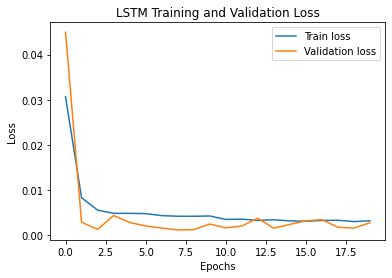

In [9]:
# Train the model (set epochs and batch size as per your computational power)
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test))

# Plot training history (optional)
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('LSTM Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 347ms/step


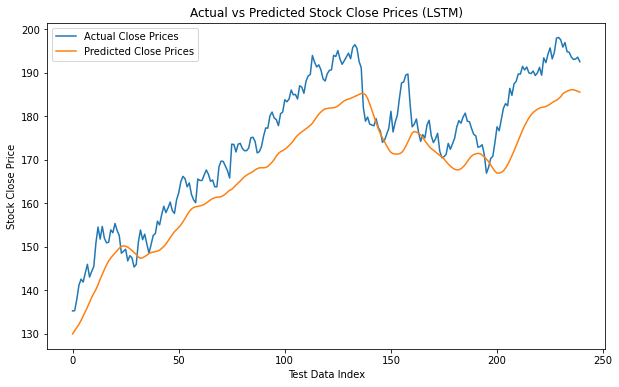

In [10]:
# Make predictions
y_pred = model.predict(X_test)

# Inverse scale the predictions and actual values to the original scale
y_test_unscaled = scaler.inverse_transform(np.concatenate([np.zeros((len(y_test), len(features))), y_test.reshape(-1, 1)], axis=1))[:, -1]
y_pred_unscaled = scaler.inverse_transform(np.concatenate([np.zeros((len(y_pred), len(features))), y_pred], axis=1))[:, -1]

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_unscaled, label='Actual Close Prices')
plt.plot(y_pred_unscaled, label='Predicted Close Prices')
plt.title('Actual vs Predicted Stock Close Prices (LSTM)')
plt.xlabel('Test Data Index')
plt.ylabel('Stock Close Price')
plt.legend()
plt.show()


In [11]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_test_unscaled, y_pred_unscaled)
print(f'Mean Absolute Error (MAE): {mae}')


Mean Absolute Error (MAE): 7.382007201838612
